# Items to be covered 

1. Introduce fine-tuning transfer learning with TF
2. Intriduce Keras Functional API to build models
3. Using a small dataset to experiement faster (e.g. 10% of traning samples)
4. Data augmentation within the model
5. Running series of experiments on Food Vision Data
6. Introduce ModelCheckpoint callback to save intemediate training results

In [1]:
!nvidia-smi

Sun Dec 21 06:14:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 590.44.01              Driver Version: 591.44         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   44C    P8              9W /   73W |     374MiB /  12227MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimage 
import keras 
from helpers import walk_data_directory, import_and_create_train_test_ds, display_tensorboard_logs, view_all_images_in_a_batch_ds, create_tensorboard_callback, plot_loss_curves

In [3]:
data_dir = "data/10_food_classes_10_percent/"
train_dir = "data/10_food_classes_10_percent/train/"
test_dir = "data/10_food_classes_10_percent/test" 

In [4]:
walk_data_directory(data_dir)

There are 2 folders and 0 in 'data/10_food_classes_10_percent/'
There are 10 folders and 0 in 'data/10_food_classes_10_percent/test'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/chicken_curry'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/chicken_wings'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/fried_rice'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/grilled_salmon'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/hamburger'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/ice_cream'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/pizza'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/ramen'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/steak'
There are 0 folders and 250 in 'data/10_food_classes_10_percent/test/sushi'
There are 10 folders and 0 in 'data/10_food_classes_10_percent/train'

In [5]:
train_ds, test_ds = import_and_create_train_test_ds(train_dir=train_dir,
                                                   test_dir=test_dir)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
class_names = train_ds.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

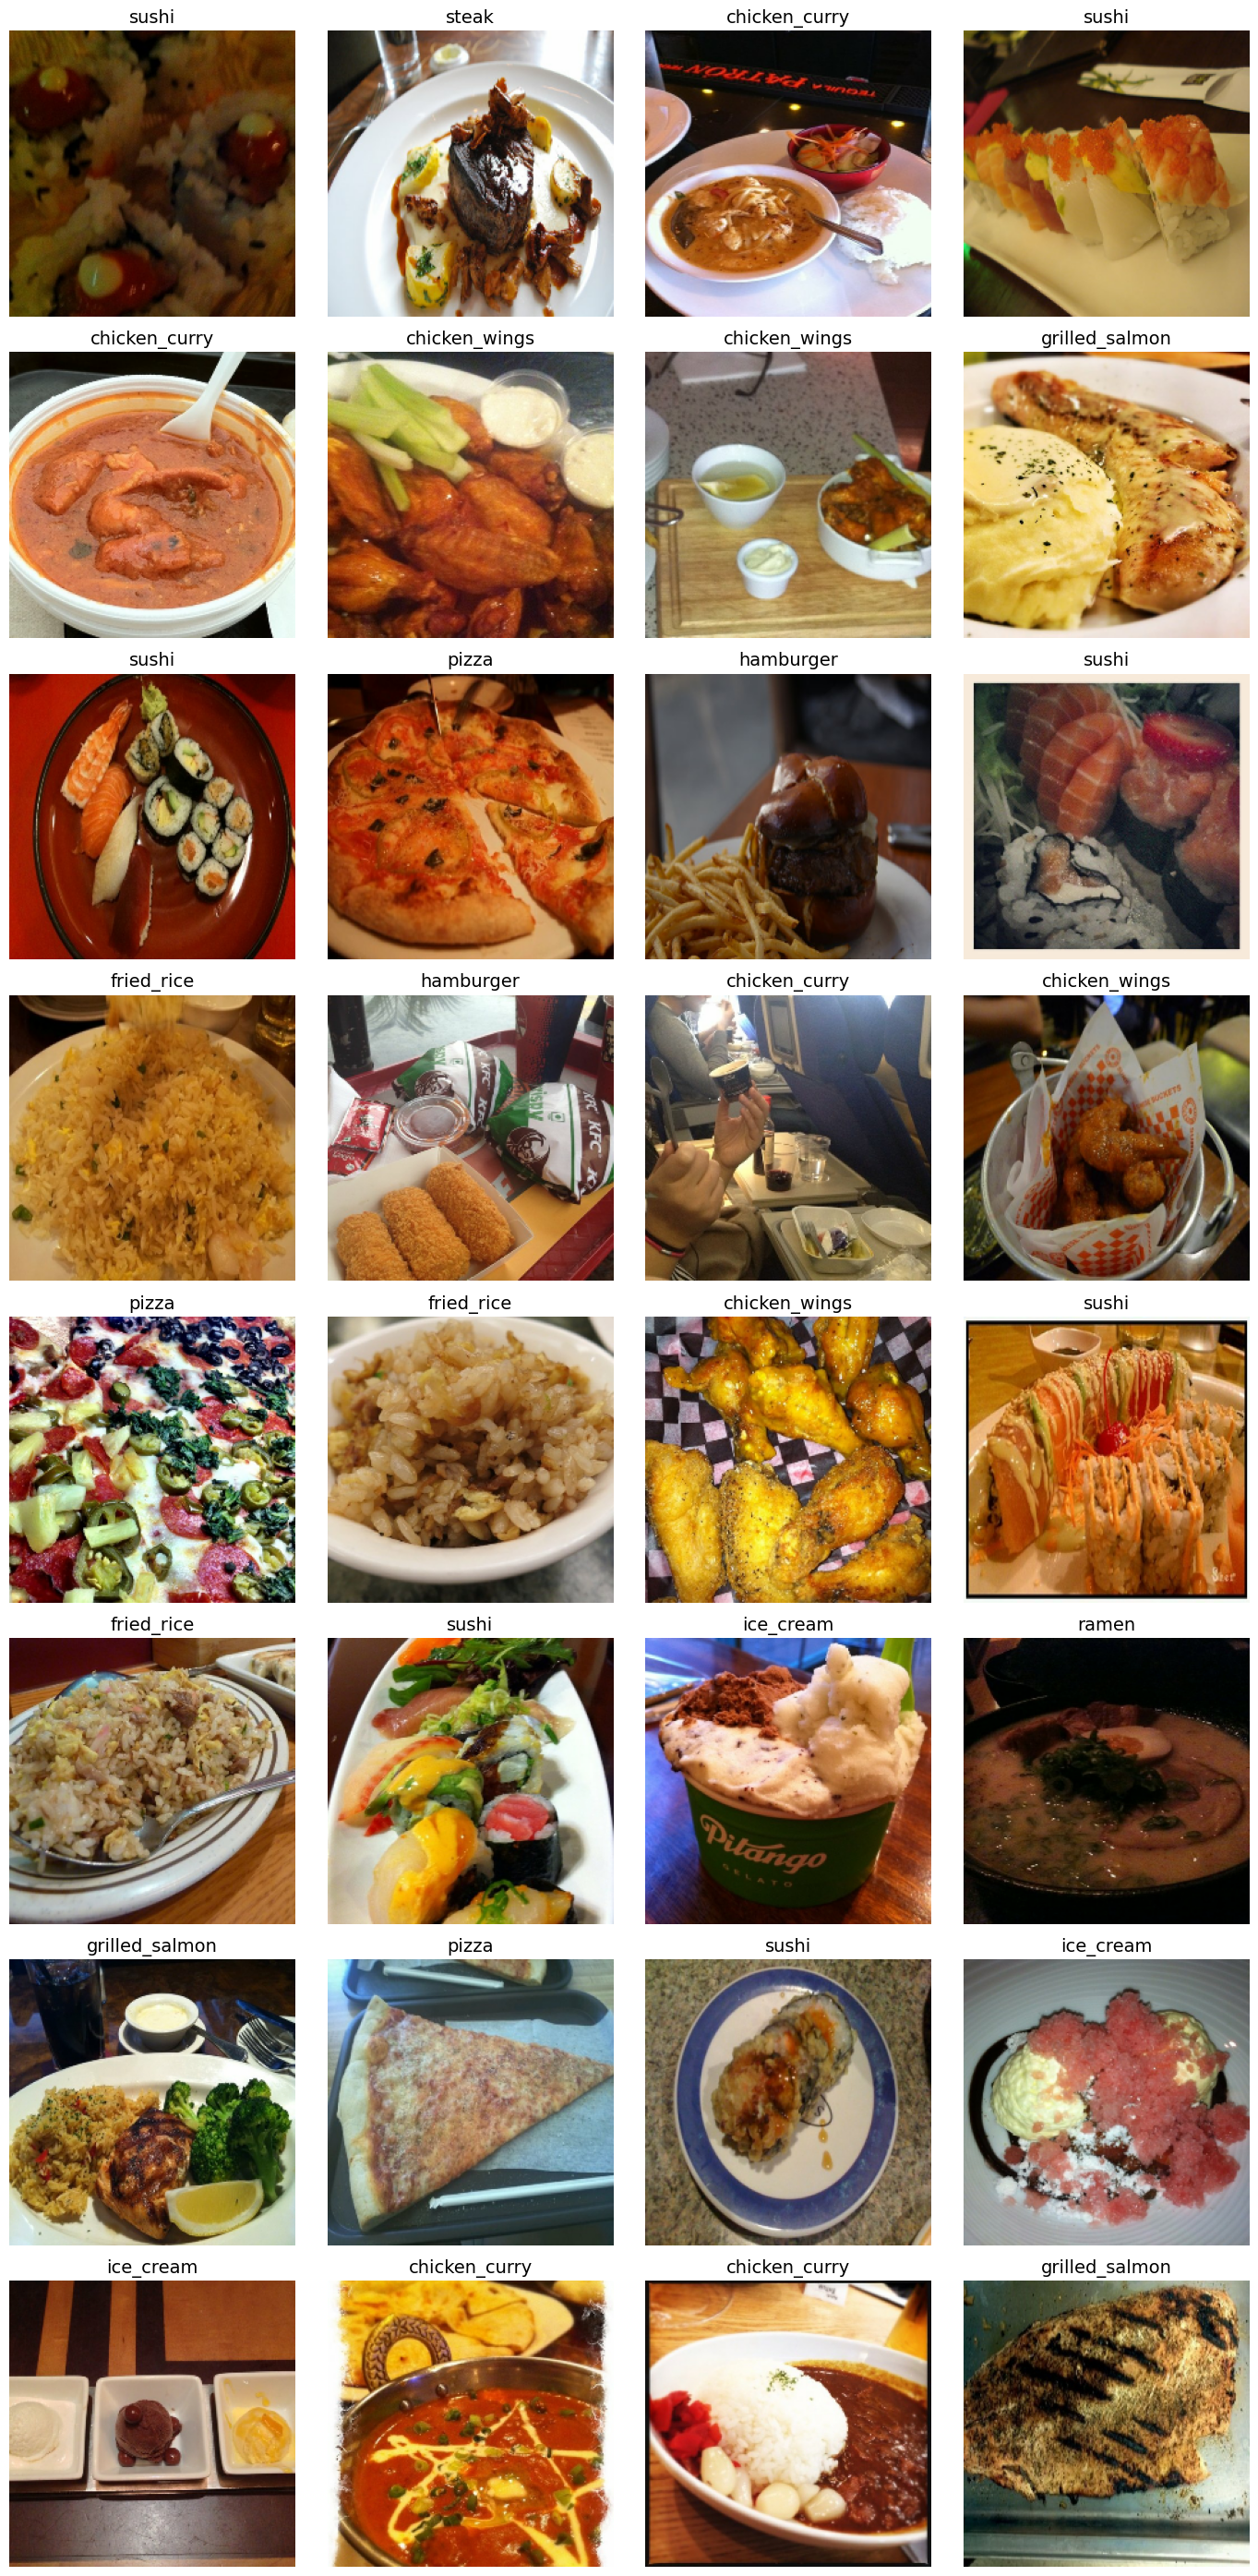

In [7]:
view_all_images_in_a_batch_ds(train_ds)

In [14]:
def build_efficientv2_models(variant="B0",
                             num_classes=len(class_names), 
                             base_trainable=False, 
                             lr=1e-3,
                             batch_size=32, 
                             dropout=0.2
                            ): 

    model_name = f"EfficientNetV2{variant}"
    try:
        BaseModel = getattr(keras.applications, model_name)
    except AttributeError:
        raise ValueError(f"Invalid EfficientNetV2 variant: {variant}")

    EFFICIENTNETV2_SIZES = {
        "B0": (224, 224),
        "B1": (240, 240),
        "B2": (260, 260),
        "B3": (300, 300),
        "S":  (384, 384),
        "M":  (480, 480),
        "L":  (480, 480),
    }

    img_size = EFFICIENTNETV2_SIZES[variant]

    base_model = BaseModel(
                    include_top=False,
                    weights="imagenet",
                    input_shape=img_size + (3,),
                    pooling="avg",
                )

    base_model.trainable = base_trainable 

    inputs = keras.Input(shape=img_size+(3,), name="input_layer") 
    x = keras.applications.efficientnet_v2.preprocess_input(inputs) 
    x = base_model(x, training=False)
    # x=keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    x = keras.layers.Dropout(dropout)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax', name="output_layer")(x) 

    model = keras.Model(inputs, outputs, name=model_name) 
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(), 
        optimizer=keras.optimizers.Adam(learning_rate=lr), 
        metrics=["accuracy"]
    )
    return model

efficientnetv2b0_model = build_efficientv2_models(variant="B0", 
                                                  num_classes=len(class_names))

efficientnetv2b0_model.summary()
    

Model: "EfficientNetV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [15]:
history_efficientnetv2b0 = efficientnetv2b0_model.fit(
                                train_ds,
                                validation_data=test_ds, 
                                epochs=5, 
                                validation_steps=int(0.25 * (len(test_ds))), 
                                callbacks=[create_tensorboard_callback(
                                                        dir_name="/workspace/tensorflow/tensorboard/",
                                                        experiment_name="EfficientNetV2B0"
                                                        )
                                          ]
                            )

Saving TensorBoard log files to /workspace/tensorflow/tensorboard/EfficientNetV2B0/20251221-061738
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 444ms/step - accuracy: 0.2156 - loss: 2.1739 - val_accuracy: 0.7467 - val_loss: 1.3693
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6852 - loss: 1.3048 - val_accuracy: 0.8158 - val_loss: 0.9499
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7669 - loss: 0.9852 - val_accuracy: 0.8355 - val_loss: 0.7585
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8362 - loss: 0.7521 - val_accuracy: 0.8454 - val_loss: 0.6760
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.8483 - loss: 0.6475 - val_accuracy: 0.8382 - val_loss: 0.5519


In [16]:
for layer_number, layer in enumerate(efficientnetv2b0_model.layers): 
    print(layer_number, layer.name)

0 input_layer
1 efficientnetv2-b0
2 dropout_2
3 output_layer


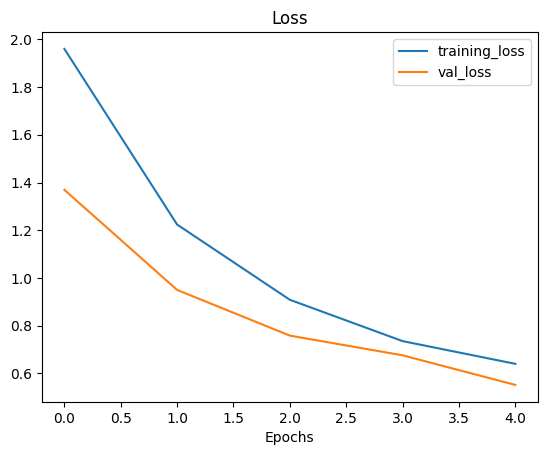

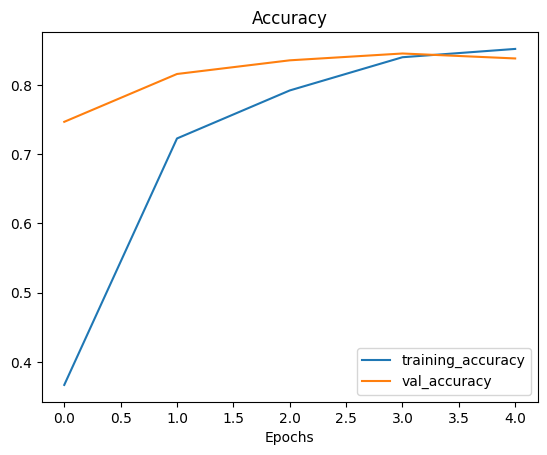

In [17]:
plot_loss_curves(history_efficientnetv2b0)